In [ ]:
# Import modules
import pandas as pd
import time
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats
import sklearn.linear_model as lm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import re
import numpy as np

In [ ]:
# Drops num amount of columns from df when the colums to be dropped are subsequently named 'drop1', 'drop2' ... 'drop{num}'
def drop_columns(df, num):
  for i in range(1, num + 1):
    df.drop(f'drop{i}', axis=1, inplace=True)

# Cleans the data by removing the extra rows that label data and duplicate players who played on multiple teams
def scrub(df):
    df = df[df['Rk'] != 'Rk']
    df = df.copy()  # Create a copy of the dataframe (prevents error)
    df = df.drop_duplicates(subset = 'Player', keep = 'first')
    return df

# Gets all data for given year and returns the dataframes
def get_year_data_teams(year):

    # Set url for different pages
    team_stats_url = 'https://www.basketball-reference.com/leagues/NBA_' + year + '.html'
    yoffs_team_stats_url = 'https://www.basketball-reference.com/playoffs/NBA_' + year + '.html'

    # Panda read the html of the urls
    team_stats = pd.read_html(team_stats_url)
    yoffs_team_stats = pd.read_html(yoffs_team_stats_url)

    # Set team dfs to specific index values for where on the page the tables appear
    team_pg_df = team_stats[4]
    team_advanced_df = team_stats[10]
    team_shooting_df = team_stats[11]

    # Set playoff team dfs to specific index values for where on the page the tables appear
    yoffs_team_pg_df = yoffs_team_stats[16]
    yoffs_team_advanced_df = yoffs_team_stats[20]

    # Make specific edits based on table format for team advanced stats
    team_advanced_df.columns = ('Rk', 'Team', 'Age','W', 'L', 'PW', 'PL', 'drop1', 'drop2', 'drop3', 'ORtg', 'DRtg', 'NRtg', 'Pace', 'FTr', '3PAr',	'TS%', 'drop4', 'eFG%',	'TOV%',	'ORB%',	'FT/FGA', 'drop5', 'O eFG%', 'O TOV%',	'DRB%',	'O FT/FGA', 'drop6', 'drop7', 'drop8', 'drop9')
    drop_columns(team_advanced_df, 9)

    # Make specific edits based on table format for playoff team advanced stats
    yoffs_team_advanced_df.columns = ('Rk','Team', 'Age', 'W', 'L',	'W/L%', 'PW',	'PL', 'ORtg',	'DRtg',	'NRtg',	'Pace',	'FTr', '3PAr',	'TS%', 'drop1', 'eFG%',	'TOV%',	'ORB%',	'FT/FGA', 'drop2', 'O eFG%', 'O TOV%',	'DRB%',	'O FT/FGA')
    drop_columns(yoffs_team_advanced_df, 2)

    # Make specific edits based on table format for team shooting stats
    team_shooting_df.columns = ('Rk',	'Team',	'G',	'MP',	'FG%',	'Dist.', 'drop1', '2P FGA%',	'0-3 FGA%', '3-10 FGA%', '10-16 FGA%', '16-3P FGA%', '3P FGA%', 'drop2', '2P FG%', '0-3 FG%',	'3-10 FG%',	'10-16 FG%', '16-3P FG%', '3P FG%', 'drop3', '2P %FGAst\'d',	'3P %FGAst\'d', 'drop4', '%FGA dunks',	'Md. dunks', 'drop5',	'drop6',	'drop7', 'drop8', '%3PA corner',	'3P% corner', 'drop9', 'drop10',	'drop11')
    drop_columns(team_shooting_df, 11)

    return (team_pg_df, team_advanced_df, team_shooting_df, yoffs_team_pg_df, yoffs_team_advanced_df)

# Gets player data for given year and returns the dataframes
def get_year_data_players(year, playoffs):
    # Set url for different pages
    players_pg_url = 'https://www.basketball-reference.com/leagues/NBA_' + year + '_per_game.html'
    players_advanced_url = 'https://www.basketball-reference.com/leagues/NBA_' + year + '_advanced.html'
    players_shooting_url = 'https://www.basketball-reference.com/leagues/NBA_' + year + '_shooting.html'

    # Panda read the html of the urls
    players_pg = pd.read_html(players_pg_url)
    time.sleep(2.5)
    players_advanced = pd.read_html(players_advanced_url)
    time.sleep(2.5)
    players_shooting = pd.read_html(players_shooting_url)

    # Set player dfs to first tables on pages
    players_pg_df = players_pg[0]
    players_advanced_df = players_advanced[0]
    players_shooting_df = players_shooting[0]

    # Make specific edits based on table format for advanced player stats and advanced player playoff stats
    players_advanced_df.drop('Unnamed: 19', axis=1, inplace=True)
    players_advanced_df.drop('Unnamed: 24', axis=1, inplace=True)

    # Make specific edits based on table format for player shooting stats and playoff player shooting stats
    players_shooting_df.columns = ('Rk',	'Player',	'Pos',	'Age',	'Tm',	'G', 'MP', 'FG%', 'Dist.', 'drop1',	'2P FGA%', '0-3 FGA%', '3-10 FGA%', '10-16 FGA%', '16-3P FGA%', '3P FGA%', 'drop2', '2P FG%', '0-3 FG%',	'3-10 FG%',	'10-16 FG%', '16-3P FG%', '3P FG%', 'drop3', '2P %FGAst\'d',	'3P %FGAst\'d', 'drop4', '%FGA dunks',	'Md. dunks', 'drop5', '%3PA corner',	'3P% corner', 'drop6', 'drop7',	'drop8')
    drop_columns(players_shooting_df, 8)

    # Scrub the dfs for player advanced and per game stats
    players_pg_df = scrub(players_pg_df)
    players_advanced_df = scrub(players_advanced_df)
    players_shooting_df = scrub(players_shooting_df)

    # Filter regular season player dfs so that only select columns are kept
    players_pg_df = players_pg_df.loc[:, ['Player', 'Pos', 'Age', 'Tm', 'G', 'MP', 'FG%', '3P%', 'FTA', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS']]
    players_advanced_df = players_advanced_df.loc[:, ['Player', 'PER', 'TS%', 'TOV%', 'USG%', 'WS', 'WS/48', 'BPM', 'VORP']]
    players_shooting_df = players_shooting_df.loc[:, ['Player', 'Dist.', '%FGA dunks']]

    if playoffs == True:
        # Set url of different playoff pages
        yoffs_players_pg_url = 'https://www.basketball-reference.com/playoffs/NBA_' + year + '_per_game.html'
        yoffs_players_advanced_url = 'https://www.basketball-reference.com/playoffs/NBA_' + year + '_advanced.html'
        yoffs_players_shooting_url = 'https://www.basketball-reference.com/playoffs/NBA_' + year + '_shooting.html'

        # Panda read the html of the urls
        yoffs_players_pg = pd.read_html(yoffs_players_pg_url)
        time.sleep(2.5)
        yoffs_players_advanced = pd.read_html(yoffs_players_advanced_url)
        time.sleep(2.5)
        yoffs_players_shooting = pd.read_html(yoffs_players_shooting_url)

        # Set playoffs player dfs to first tables on pages
        yoffs_players_pg_df = yoffs_players_pg[0]
        yoffs_players_advanced_df = yoffs_players_advanced[0]
        yoffs_players_shooting_df = yoffs_players_shooting[0]

        # Make specific edits based on table format for advanced player stats and advanced player playoff stats
        yoffs_players_advanced_df.drop('Unnamed: 19', axis=1, inplace=True)
        yoffs_players_advanced_df.drop('Unnamed: 24', axis=1, inplace=True)

        # Make specific edits based on table format for player shooting stats and playoff player shooting stats
        yoffs_players_shooting_df.columns = ('Rk',	'Player',	'Pos',	'Age',	'Tm',	'G', 'MP', 'FG%', 'Dist.', 'drop1',	'2P FGA%', '0-3 FGA%', '3-10 FGA%', '10-16 FGA%', '16-3P FGA%', '3P FGA%', 'drop2', '2P FG%', '0-3 FG%',	'3-10 FG%',	'10-16 FG%', '16-3P FG%', '3P FG%', 'drop3', '2P %FGAst\'d',	'3P %FGAst\'d', 'drop4', '%FGA dunks',	'Md. dunks', 'drop5', '%3PA corner',	'3P% corner', 'drop6', 'drop7',	'drop8')
        drop_columns(yoffs_players_shooting_df, 8)

        # Scrub the dfs for player playoff advanced and per game stats
        yoffs_players_pg_df = scrub(yoffs_players_pg_df)
        yoffs_players_advanced_df = scrub(yoffs_players_advanced_df)
        yoffs_players_shooting_df = scrub(yoffs_players_shooting_df)

        # Filter playoff player stats dfs so that only select columns are kept
        yoffs_players_pg_df = yoffs_players_pg_df.loc[:, ['Player', 'Pos', 'Age', 'Tm', 'G', 'MP', 'FG%', '3P%', 'FTA', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS']]
        yoffs_players_advanced_df = yoffs_players_advanced_df.loc[:, ['Player', 'PER', 'TS%', 'TOV%', 'USG%', 'WS', 'WS/48', 'BPM', 'VORP']]
        yoffs_players_shooting_df = yoffs_players_shooting_df.loc[:, ['Player', 'Dist.', '%FGA dunks']]

        return (players_pg_df, players_advanced_df, players_shooting_df, yoffs_players_pg_df, yoffs_players_advanced_df, yoffs_players_shooting_df)
    else:
        return (players_pg_df, players_advanced_df, players_shooting_df)


# Gets specific player's stats based on a year inputted
def get_player_stats(player_name, year):
    player_stats = {}

    reg_df = all_players_dfs[f'reg_players_{year}']
    reg_player_stats = reg_df[reg_df['Player'] == player_name][['MP', 'TOV', 'PTS', 'FTA', 'AST', 'TRB', 'FG%', '3P%', 'TS%', 'PER']]
    reg_player_stats.columns = [col + '_regular' for col in reg_player_stats.columns]
    if not reg_player_stats.empty:
        player_stats.update(reg_player_stats.to_dict(orient='records')[0])
    else:
        return None

    playoff_df = all_players_dfs[f'yoffs_players_{year}']
    playoff_player_stats = playoff_df[playoff_df['Player'] == player_name][['MP', 'TOV', 'PTS', 'FTA', 'AST', 'TRB', 'FG%', '3P%', 'TS%', 'PER']]
    playoff_player_stats.columns = [col + '_playoff' for col in playoff_player_stats.columns]
    if not playoff_player_stats.empty:
        player_stats.update(playoff_player_stats.to_dict(orient='records')[0])
    else:
        return None

    return player_stats

# Gets specific player's stats (regular season only) on a year inputted
def get_regular_stats(player_name, year):
    player_stats = {}

    reg_df = all_players_dfs[f'reg_players_{year}']
    reg_player_stats = reg_df[reg_df['Player'] == player_name][['MP', 'TOV', 'PTS', 'AST', 'TRB', 'FG%', '3P%', 'TS%', 'PER']]
    reg_player_stats.columns = [col + '_regular' for col in reg_player_stats.columns]
    if not reg_player_stats.empty:
        player_stats.update(reg_player_stats.to_dict(orient='records')[0])
    else:
        return None
    return player_stats

In [ ]:
# Create a dictionary that will have different dataframes for each year's player and team stats
dataframes = {}
# Iterrate through each year that we want to compile data for and add their dataframes to the dictionary
for year in range(2017, 2024):
    data = get_year_data_teams(str(year))
    dataframes[f'team_pg_df_{year}'], dataframes[f'team_advanced_df_{year}'], dataframes[f'team_shooting_df_{year}'], dataframes[f'yoffs_team_pg_df_{year}'], dataframes[f'yoffs_team_advanced_df_{year}'] = data #dataframes[f'yoffs_team_shooting_df_{year}']

# Gets rid of playoff teams without stats (they were play-in teams)
dataframes['yoffs_team_advanced_df_2023'] = dataframes['yoffs_team_advanced_df_2023'][dataframes['yoffs_team_advanced_df_2023']['L'] != 0]
dataframes['yoffs_team_pg_df_2023'] = dataframes['yoffs_team_pg_df_2023'][dataframes['yoffs_team_pg_df_2023']['G'] != 0]

In [ ]:
# Create lists for t-tests

# 3-Point attempt rate
regular_3PAr = []
yoffs_3PAr = []
# Turnovers
regular_TOV = []
yoffs_TOV = []
# Turnover Percentage
regular_TOVper = []
yoffs_TOVper = []
# Posessions per 48 minutes
regular_Pace = []
yoffs_Pace = []
# True Shooting Percentage
regular_TSper = []
yoffs_TSper = []
# Assists per possession
regular_ASTper = []
yoffs_ASTper = []
# Free Throw attempt rate
regular_FTAr = []
yoffs_FTAr = []
# Percentage of available offensive and defensive rebounds a player grabbed while on the floor
regular_RBper = []
yoffs_RBper = []
# Percentage of available offensive rebounds a player grabbed while on the floor
regular_ORBper = []
yoffs_ORBper = []
# Percentage of available defensive rebounds a player grabbed while on the floor
regular_DRBper = []
yoffs_DRBper = []
# Free Throw percentage
regular_FTper = []
yoffs_FTper = []
# 3-Point percentage
regular_3Pper = []
yoffs_3Pper = []
# Defensive Rating, points allowed per 100 possesions
regular_DRtg = []
yoffs_DRtg = []
# Offensive Rating, points produced or scored per 100 possesions
regular_ORtg = []
yoffs_ORtg = []
# For plot, average age
age = []
# For plot, playoffs wins
yoffs_wins = []

# Create list formatted for each year (with data)
for year in range(2017, 2024):
  df_regular_advanced = dataframes[f'team_advanced_df_{year}']
  df_regular_advanced = df_regular_advanced[df_regular_advanced['Team'] != 'League Average']
  df_yoffs_advanced = dataframes[f'yoffs_team_advanced_df_{year}']
  df_yoffs_advanced = df_yoffs_advanced[df_yoffs_advanced['Team'] != 'League Average']
  df_regular_pg = dataframes[f'team_pg_df_{year}']
  df_regular_pg = df_regular_pg[df_regular_pg['Team'] != 'League Average']
  df_yoffs_pg = dataframes[f'yoffs_team_pg_df_{year}']
  df_yoffs_pg = df_yoffs_pg[df_yoffs_pg['Tm'] != 'League Average']
  df_regular_shooting = dataframes[f'team_shooting_df_{year}']
  df_regular_shooting = df_regular_shooting[df_regular_shooting['Team'] != 'League Average']

  df_regular_advanced = df_regular_advanced[df_regular_advanced['Team'].str.endswith('*')]
  df_regular_pg = df_regular_pg[df_regular_pg['Team'].str.endswith('*')]

# Specific for 2023 (play-in)
  if year == 2023:
      df_regular_advanced = df_regular_advanced[df_regular_advanced['Team'] != 'New Orleans Pelicans*']
      df_regular_advanced = df_regular_advanced[df_regular_advanced['Team'] != 'Oklahoma City Thunder*']
      df_regular_advanced = df_regular_advanced[df_regular_advanced['Team'] != 'Chicago Bulls*']
      df_regular_advanced = df_regular_advanced[df_regular_advanced['Team'] != 'Toronto Raptors*']
      df_regular_pg = df_regular_pg[df_regular_pg['Team'] != 'New Orleans Pelicans*']
      df_regular_pg = df_regular_pg[df_regular_pg['Team'] != 'Oklahoma City Thunder*']
      df_regular_pg = df_regular_pg[df_regular_pg['Team'] != 'Chicago Bulls*']
      df_regular_pg = df_regular_pg[df_regular_pg['Team'] != 'Toronto Raptors*']

  # For t-tests
  regular_3PAr = regular_3PAr + df_regular_advanced['3PAr'].tolist()
  yoffs_3PAr = yoffs_3PAr + df_yoffs_advanced['3PAr'].tolist()
  regular_TOV = regular_TOV + df_regular_pg['TOV'].tolist()
  yoffs_TOV = yoffs_TOV + df_yoffs_pg['TOV'].tolist()
  regular_TOVper = regular_TOVper + df_regular_advanced['TOV%'].tolist()
  yoffs_TOVper = yoffs_TOVper + df_yoffs_advanced['TOV%'].tolist()
  regular_Pace = regular_Pace + df_regular_advanced['Pace'].tolist()
  yoffs_Pace = yoffs_Pace + df_yoffs_advanced['Pace'].tolist()
  regular_TSper = regular_TSper + df_regular_advanced['TS%'].tolist()
  yoffs_TSper = yoffs_TSper + df_yoffs_advanced['TS%'].tolist()
  regular_ASTper = regular_ASTper + df_regular_pg['AST'].tolist()
  yoffs_ASTper = yoffs_ASTper + df_yoffs_pg['AST'].tolist()
  regular_FTAr = regular_FTAr + df_regular_advanced['FTr'].tolist()
  yoffs_FTAr = yoffs_FTAr + df_yoffs_advanced['FTr'].tolist()
  regular_RBper = regular_RBper + df_regular_advanced['ORB%'].tolist() + df_regular_advanced['DRB%'].tolist()
  yoffs_RBper = yoffs_RBper + df_yoffs_advanced['ORB%'].tolist() + df_yoffs_advanced['DRB%'].tolist()
  regular_ORBper = regular_ORBper + df_regular_advanced['ORB%'].tolist()
  yoffs_ORBper = yoffs_ORBper + df_yoffs_advanced['ORB%'].tolist()
  regular_DRBper = regular_DRBper + df_regular_advanced['DRB%'].tolist()
  yoffs_DRBper = yoffs_DRBper + df_yoffs_advanced['DRB%'].tolist()
  regular_FTper = regular_FTper + df_regular_pg['FT%'].tolist()
  yoffs_FTper = yoffs_FTper + df_yoffs_pg['FT%'].tolist()
  regular_3Pper = regular_3Pper + df_regular_pg['3P%'].tolist()
  yoffs_3Pper = yoffs_3Pper + df_yoffs_pg['3P%'].tolist()
  regular_DRtg = regular_DRtg + df_regular_advanced['DRtg'].tolist()
  yoffs_DRtg = yoffs_DRtg + df_yoffs_advanced['DRtg'].tolist()
  regular_ORtg = regular_ORtg + df_regular_advanced['ORtg'].tolist()
  yoffs_ORtg = yoffs_ORtg + df_yoffs_advanced['ORtg'].tolist()
  #For plots
  age = age + df_yoffs_advanced['Age'].tolist()
  yoffs_wins = yoffs_wins + df_yoffs_advanced['W'].tolist()

# Turns list of assists per game into assists per 100 possessions, accounts for the change in pace in the playoffs
for i in range(len(regular_ASTper)):
    regular_ASTper[i] = regular_ASTper[i] / regular_Pace[i]
for i in range(len(yoffs_ASTper)):
    yoffs_ASTper[i] = yoffs_ASTper[i] / yoffs_Pace[i]

In [ ]:
t_3PAr, p_3PAr = scipy.stats.ttest_ind(regular_3PAr, yoffs_3PAr)

#t_TOV, p_TOV = scipy.stats.ttest_ind(regular_TOV, yoffs_TOV)

t_TOVper, p_TOVper = scipy.stats.ttest_ind(regular_TOVper, yoffs_TOVper)
t_Pace, p_Pace = scipy.stats.ttest_ind(regular_Pace, yoffs_Pace)
t_TSper, p_TSper = scipy.stats.ttest_ind(regular_TSper, yoffs_TSper)
t_ASTper, p_ASTper = scipy.stats.ttest_ind(regular_ASTper, yoffs_ASTper)
t_FTAr, p_FTAr = scipy.stats.ttest_ind(regular_FTAr, yoffs_FTAr)

#t_RBper, p_RBper = scipy.stats.ttest_ind(regular_RBper, yoffs_RBper)

t_ORBper, p_ORBper = scipy.stats.ttest_ind(regular_ORBper, yoffs_ORBper)
t_DRBper, p_DRBper = scipy.stats.ttest_ind(regular_DRBper, yoffs_DRBper)
t_FTper, p_FTper = scipy.stats.ttest_ind(regular_FTper, yoffs_FTper)
t_3Pper, p_3Pper = scipy.stats.ttest_ind(regular_3Pper, yoffs_3Pper)
t_DRtg, p_DRtg = scipy.stats.ttest_ind(regular_DRtg, yoffs_DRtg)
t_ORtg, p_ORtg = scipy.stats.ttest_ind(regular_ORtg, yoffs_ORtg)

print("p_3PAr: " + str(p_3PAr))

#print("p_TOV: " + str(p_TOV))

print("p_TOVper: " + str(p_TOVper))
print("p_Pace: " + str(p_Pace))
if t_Pace > 0:
  print("\tGoes down in the playoffs")
else:
  print("\tGoes up in the playoffs")

print("p_TSper: " + str(p_TSper))
if t_TSper > 0:
  print("\tGoes down in the playoffs")
else:
  print("\tGoes up in the playoffs")

print("p_ASTper: " + str(p_ASTper))
if t_ASTper > 0:
  print("\tGoes down in the playoffs")
else:
  print("\tGoes up in the playoffs")

print("p_FTAr: " + str(p_FTAr))
if t_FTAr > 0:
  print("\tGoes down in the playoffs")
else:
  print("\tGoes up in the playoffs")

#print("p_RBper: " + str(p_RBper))

print("p_ORBper: " + str(p_ORBper))
if t_ORBper > 0:
  print("\tGoes down in the playoffs")
else:
  print("\tGoes up in the playoffs")

print("p_DRBper: " + str(p_DRBper))
print("p_FTper: " + str(p_FTper))
print("p_3Pper: " + str(p_3Pper))
if t_3Pper > 0:
  print("\tGoes down in the playoffs")
else:
  print("\tGoes up in the playoffs")

print("p_DRtg: " + str(p_DRtg))
if t_DRtg > 0:
  print("\tGoes down in the playoffs")
else:
  print("\tGoes up in the playoffs")

print("p_ORtg: " + str(p_ORtg))
if t_ORtg > 0:
  print("\tGoes down in the playoffs")
else:
  print("\tGoes up in the playoffs")

p_3PAr: 0.3499305159491919
p_TOVper: 0.325536416060924
p_Pace: 9.070560483091148e-06
	Goes down in the playoffs
p_TSper: 3.9962699882325785e-07
	Goes down in the playoffs
p_ASTper: 1.1926210305755653e-07
	Goes down in the playoffs
p_FTAr: 0.0124863183485744
	Goes up in the playoffs
p_ORBper: 0.03545833287334975
	Goes down in the playoffs
p_DRBper: 0.892307080904594
p_FTper: 0.7729226892325743
p_3Pper: 4.8480339735336885e-05
	Goes down in the playoffs
p_DRtg: 5.823164905566909e-07
	Goes up in the playoffs
p_ORtg: 3.338203154451073e-06
	Goes down in the playoffs


Text(0.5, 0.98, 'Mean Team Statistics')

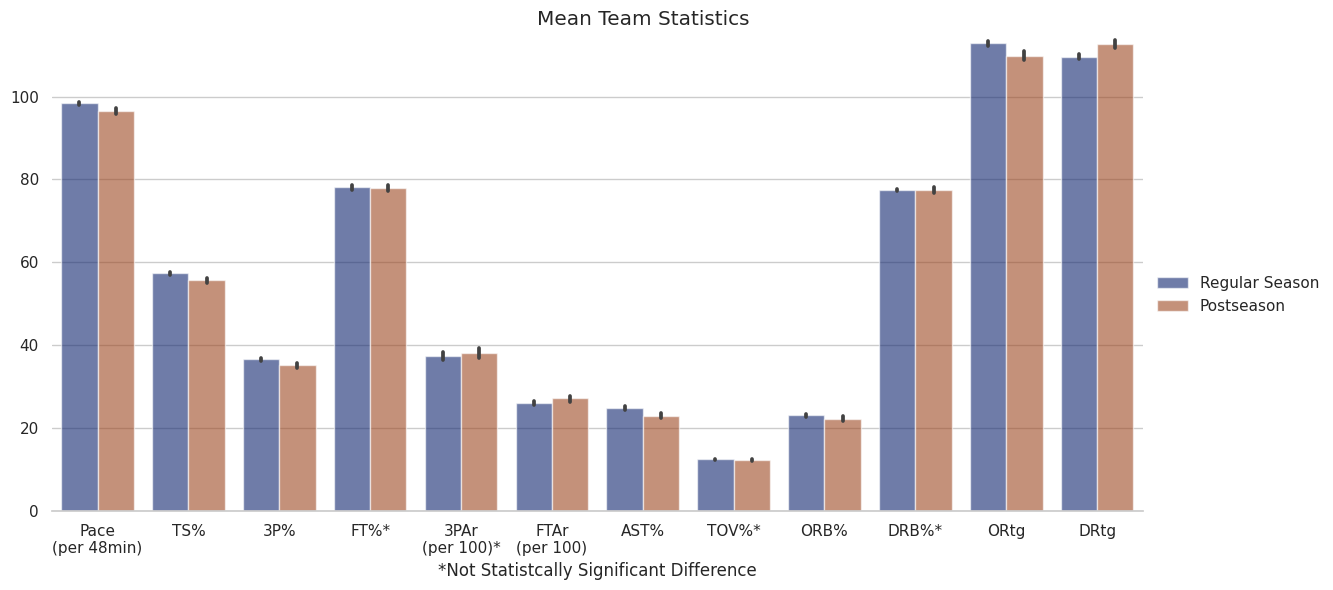

In [ ]:
# Creating a dataframe of all the data used in the t-tests

# Scaling Data so percentages are not decimals
regular_TSper_Scaled = np.array(regular_TSper) * 100
yoffs_TSper_Scaled = np.array(yoffs_TSper) * 100
regular_3Pper_Scaled = np.array(regular_3Pper) * 100
yoffs_3Pper_Scaled = np.array(yoffs_3Pper) * 100
regular_FTper_Scaled = np.array(regular_FTper) * 100
yoffs_FTper_Scaled = np.array(yoffs_FTper) * 100
regular_3PAr_Scaled = np.array(regular_3PAr) * 100
yoffs_3PAr_Scaled = np.array(yoffs_3PAr) * 100
regular_FTAr_Scaled = np.array(regular_FTAr) * 100
yoffs_FTAr_Scaled = np.array(yoffs_FTAr) * 100
regular_ASTper_Scaled = np.array(regular_ASTper) * 100
yoffs_ASTper_Scaled = np.array(yoffs_ASTper) * 100

# Creating a dataframe for the regular season data
df_ttests_regular = pd.DataFrame({
    'Pace\n(per 48min)': regular_Pace,
    'TS%': regular_TSper_Scaled,
    '3P%': regular_3Pper_Scaled,
    'FT%*': regular_FTper_Scaled,
    '3PAr\n(per 100)*': regular_3PAr_Scaled,
    'FTAr\n(per 100)': regular_FTAr_Scaled,
    'AST%': regular_ASTper_Scaled,
    'TOV%*': regular_TOVper,
    'ORB%': regular_ORBper,
    'DRB%*': regular_DRBper,
    'ORtg': regular_ORtg,
    'DRtg': regular_DRtg,
})

# Creating a dataframe for the postseason data
df_ttests_yoffs = pd.DataFrame({
    'Pace\n(per 48min)': yoffs_Pace,
    'TS%': yoffs_TSper_Scaled,
    '3P%': yoffs_3Pper_Scaled,
    'FT%*': yoffs_FTper_Scaled,
    '3PAr\n(per 100)*': yoffs_3PAr_Scaled,
    'FTAr\n(per 100)': yoffs_FTAr_Scaled,
    'AST%': yoffs_ASTper_Scaled,
    'TOV%*': yoffs_TOVper,
    'ORB%': yoffs_ORBper,
    'DRB%*': yoffs_DRBper,
    'ORtg': yoffs_ORtg,
    'DRtg': yoffs_DRtg,
})

# Combining dataframes with a column stating which dataframe it came from
df_ttests = pd.concat([df_ttests_regular, df_ttests_yoffs], keys=['Regular Season', 'Postseason']).reset_index()
df_ttests['Regular or Yoffs'] = df_ttests['level_0']
df_ttests = df_ttests.drop('level_0', axis=1)
df_ttests = df_ttests.drop('level_1', axis=1)

# Prepping df to be displayed by a catplot
df_ttests = pd.melt(df_ttests, id_vars=['Regular or Yoffs'], var_name='Statistic', value_name='Data')

# Displays means
sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=df_ttests, kind="bar",
    x="Statistic", y="Data", hue="Regular or Yoffs",
    errorbar="ci", palette="dark", alpha=.6, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("*Not Statistcally Significant Difference", "")
g.legend.set_title("")
g.fig.suptitle("Mean Team Statistics")

In [ ]:
# Regular season wins
regular_wins = []
# Assist percentage
regular_2pASTper = []
regular_3pASTper = []
regular_ASTper = []
# 2-point field goals
regular_2pFG = []
# 3-point field goals
regular_3pFG = []
# Field goals
regular_FG = []

# Creating dataframe for catplot
df_regular_shooting_full_allYears = pd.DataFrame()

# Filling dataframe for catplot
for year in range(2017, 2024):
  df_regular_pg_full = dataframes[f'team_pg_df_{year}']
  df_regular_pg_full = df_regular_pg_full[df_regular_pg_full['Team'] != 'League Average']
  df_regular_pg_full = df_regular_pg_full.sort_values(by='Team')
  df_regular_advanced_full = dataframes[f'team_advanced_df_{year}']
  df_regular_advanced_full = df_regular_advanced_full[df_regular_advanced_full['Team'] != 'League Average']
  df_regular_advanced_full = df_regular_advanced_full.sort_values(by='Team')
  df_regular_shooting_full = dataframes[f'team_shooting_df_{year}']
  df_regular_shooting_full = df_regular_shooting_full[df_regular_shooting_full['Team'] != 'League Average']
  df_regular_shooting_full = df_regular_shooting_full.sort_values(by='Team')
  regular_wins = regular_wins + df_regular_advanced_full['W'].tolist()
  regular_2pASTper = regular_2pASTper + df_regular_shooting_full['2P %FGAst\'d'].tolist()
  regular_3pASTper = regular_3pASTper + df_regular_shooting_full['3P %FGAst\'d'].tolist()
  regular_2pFG = regular_2pFG + df_regular_pg_full['2P'].tolist()
  regular_3pFG = regular_3pFG + df_regular_pg_full['3P'].tolist()
  regular_FG = regular_FG + df_regular_pg_full['FG'].tolist()

  df_regular_shooting_full_allYears = pd.concat([df_regular_shooting_full_allYears, df_regular_shooting_full], axis=0)

# Prepping df to be displayed by a catplot
df_regular_shooting_full_allYears['Playoffs?'] = np.where(df_regular_shooting_full_allYears['Team'].str.endswith('*'), 'Made Playoffs', 'Missed Playoffs')
df_regular_shooting_full_allYears = df_regular_shooting_full_allYears[['0-3 FG%', '3-10 FG%', '10-16 FG%', '16-3P FG%', '3P FG%', "Playoffs?"]]
df_regular_shooting_full_allYears = pd.melt(df_regular_shooting_full_allYears, id_vars=['Playoffs?'], var_name='Distances', value_name='Percentages')

# Creating list for scatterplot
regular_ASTper = [None] * len(regular_wins)

# Filling the list regular_ASTper where the values are the fraction of field goals that are assisted by the team that year
for i in range(len(regular_wins)):
  regular_2pASTper[i] = regular_2pASTper[i] * regular_2pFG[i]
  regular_3pASTper[i] = regular_3pASTper[i] * regular_3pFG[i]
  regular_ASTper[i] = (regular_2pASTper[i] + regular_3pASTper[i]) / regular_FG[i]

Text(0.5, 0.98, 'Team Field Goal Percentage by Distance')

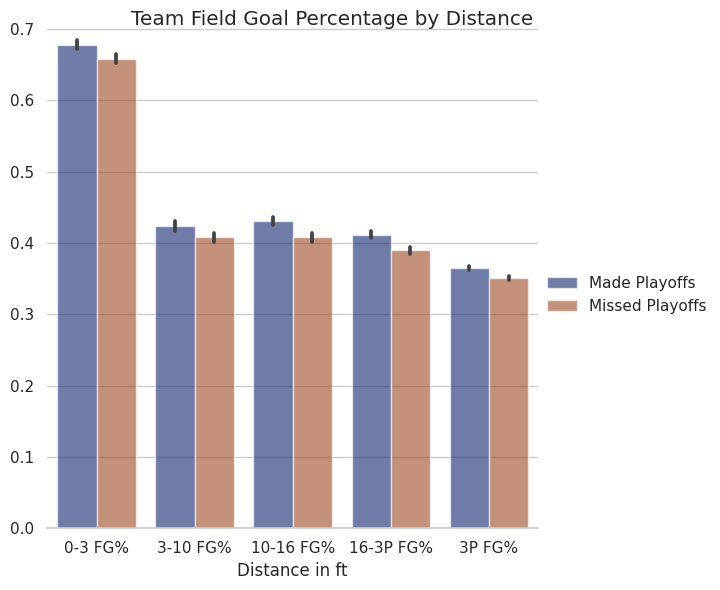

In [ ]:
sns.set_theme(style="whitegrid")

g = sns.catplot(
    data=df_regular_shooting_full_allYears, kind="bar",
    x="Distances", y="Percentages", hue="Playoffs?",
    errorbar="ci", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("Distance in ft", "")
g.legend.set_title("")
g.fig.suptitle("Team Field Goal Percentage by Distance")

R-Squared Value: 0.010877377708837566


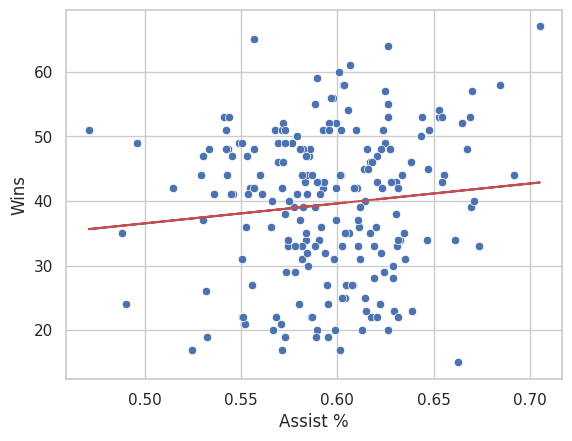

In [ ]:
# Createing Data Frame of teams Assist Percentage and Wins
ASTper_to_wins_data = pd.DataFrame({
    'Assist %': regular_ASTper,
    'Wins': regular_wins
})

# Plotting Assist Percentage to Wins Scatterplot
sns.set_theme(style="whitegrid")
sns.scatterplot(x='Assist %', y='Wins', data=ASTper_to_wins_data)

# Calculating and plotting line of best fit
linear_model = LinearRegression()
new_regular_ASTper = np.array(regular_ASTper)
new_regular_ASTper = new_regular_ASTper.reshape(-1, 1)
linear_model.fit(new_regular_ASTper, regular_wins)
regular_wins_hat = linear_model.predict(new_regular_ASTper)
plt.plot(new_regular_ASTper, regular_wins_hat, 'r')

r2_pts = linear_model.score(new_regular_ASTper, regular_wins)
print("R-Squared Value:", r2_pts)



In [ ]:
# Create range of years that data extends across
years = range(2017, 2024)

# Create a dictionary that will have different dataframes for each year's player and team stats
all_players_dfs = {}

# Iterrate through each year that we want to compile data for and add their dataframes to the dictionary
for year in years:
    data = get_year_data_players(str(year), True)
    dataframes[f'players_pg_df_{year}'], dataframes[f'players_advanced_df_{year}'], dataframes[f'players_shooting_df_{year}'], dataframes[f'yoffs_players_pg_df_{year}'], dataframes[f'yoffs_players_advanced_df_{year}'], dataframes[f'yoffs_players_shooting_df_{year}'] = data
data = get_year_data_players('2024', False)
dataframes['players_pg_df_2024'], dataframes['players_advanced_df_2024'], dataframes['players_shooting_df_2024'] = data
all_players_dfs['reg_players_2024'] = pd.merge(dataframes['players_pg_df_2024'], pd.merge(dataframes['players_advanced_df_2024'], dataframes['players_shooting_df_2024'], on='Player'), on='Player')

In [ ]:
# Create new dataframes that combine regular season stats together and playoff stats together so we can easily access the stats together.
for year in years:
    all_players_dfs[f'reg_players_{year}'] = pd.merge(dataframes[f'players_pg_df_{year}'], pd.merge(dataframes[f'players_advanced_df_{year}'], dataframes[f'players_shooting_df_{year}'], on='Player'), on='Player')
    all_players_dfs[f'yoffs_players_{year}'] = pd.merge(dataframes[f'yoffs_players_pg_df_{year}'], pd.merge(dataframes[f'yoffs_players_advanced_df_{year}'], dataframes[f'yoffs_players_shooting_df_{year}'], on='Player'), on='Player')

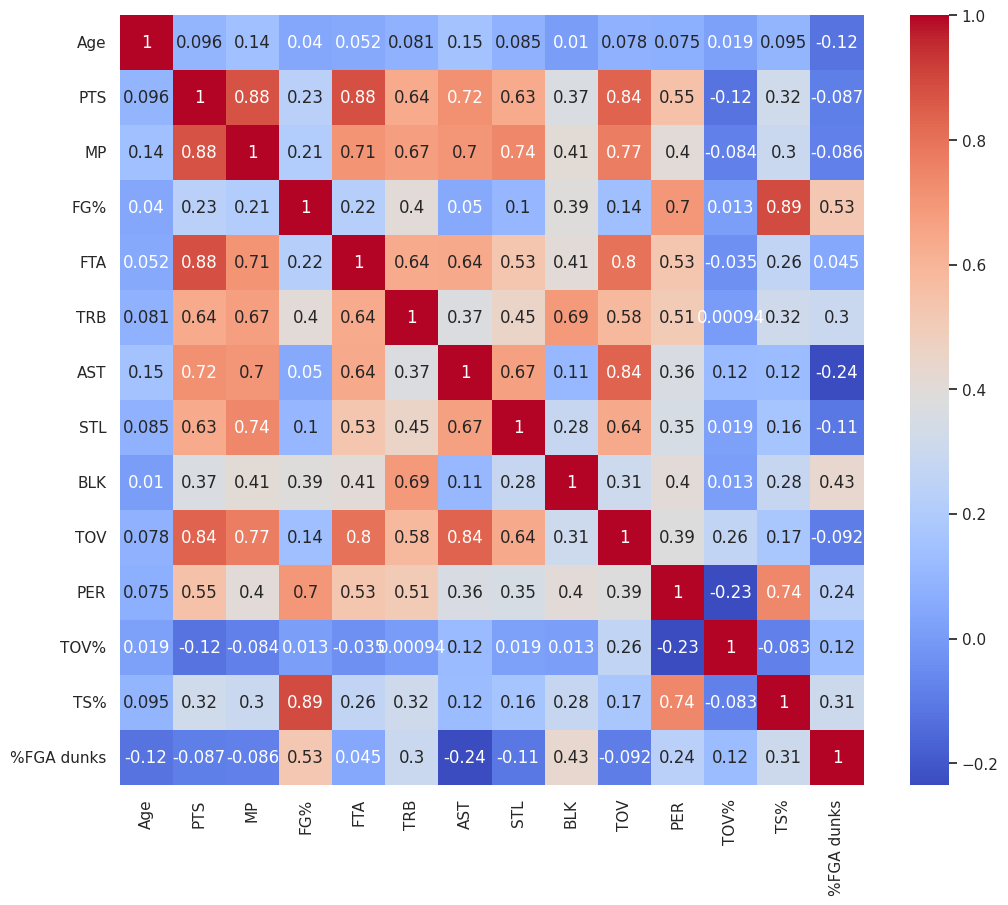

In [ ]:
# Convert selected columns to numeric values for all years
selected_columns = ['Age', 'PTS', 'MP', 'FG%', 'FTA', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PER', 'TOV%', 'TS%', '%FGA dunks']
for year in years:
    for col in selected_columns:
        all_players_dfs[f'reg_players_{year}'][col] = pd.to_numeric(all_players_dfs[f'reg_players_{year}'][col], errors='coerce')

# Create a correlation matrix
correlation_matrix = pd.concat([all_players_dfs[f'reg_players_{year}'][selected_columns] for year in years]).corr()

# Create a heatmap
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [ ]:
# List of the top NBA players in recent years to train linear regression model for playoff success.
player_names = [
    "LeBron James",
    "Kevin Durant",
    "Giannis Antetokounmpo",
    "Stephen Curry",
    "Kawhi Leonard",
    "James Harden",
    "Anthony Davis",
    "Luka Dončić",
    "Joel Embiid",
    "Damian Lillard",
    "Jayson Tatum",
    "Jimmy Butler",
    "Chris Paul",
    "Karl-Anthony Towns",
    "Devin Booker",
    "Paul George",
    "Kyrie Irving",
    "Russell Westbrook",
    "Donovan Mitchell",
    "Zion Williamson",
    "Ben Simmons",
    "Jaylen Brown",
    "Khris Middleton",
    "Bam Adebayo",
    "Rudy Gobert",
    "Bradley Beal",
    "De'Aaron Fox",
    "Trae Young",
    "Deandre Ayton",
    "CJ McCollum",
    "Brandon Ingram",
    "Pascal Siakam",
    "Ja Morant",
    "Shai Gilgeous-Alexander",
    "Jrue Holiday",
    "LaMelo Ball",
    "Michael Porter Jr.",
    "DeMar DeRozan",
    "John Collins",
    "Jaren Jackson Jr.",
    "Mikal Bridges",
    "Zach LaVine",
    "Jamal Murray",
    "Fred VanVleet",
    "Kyle Lowry",
    "Dejounte Murray",
    "D'Angelo Russell"
]

Original linear regression model (less accurate)

In [ ]:
# Create empty lists to store the data
X = []  # Independent variables (regular season stats)
y_pts = []  # Dependent variable (playoff points)

# Iterate through each player and year to collect the data
for player in player_names:
    for year in years:
        player_stats = get_player_stats(player, year)
        if player_stats is not None:
            # Convert stats to numeric values and append to the lists
            X.append([float(player_stats['PTS_regular'])])
            y_pts.append(float(player_stats['PTS_playoff']))

# Convert lists to DataFrames for easier manipulation
X_df = pd.DataFrame(X, columns=['PTS_regular'])
y_pts_df = pd.DataFrame(y_pts, columns=['PTS_playoff'])

# Split the data into training and testing sets
X_train, X_test, y_pts_train, y_pts_test = train_test_split(X_df, y_pts_df, test_size=0.2, random_state=42)

# Create a linear regression model for points
model_pts = LinearRegression()
model_pts.fit(X_train, y_pts_train)

# Make predictions using the testing data
y_pts_pred = model_pts.predict(X_test)

# Evaluate the model
mse_pts = mean_squared_error(y_pts_test, y_pts_pred)
r2_pts = model_pts.score(X_test, y_pts_test)
print("Mean Squared Error:", mse_pts)
print("R-Squared Value:", r2_pts)

Mean Squared Error: 13.46762232253759
R-Squared Value: 0.695353968017262


Second linear regression model (surprisingly not that accurate)

In [ ]:
# Create empty lists to store the data
X = []  # Independent variables (regular season stats)
y_pts = []  # Dependent variable (playoff points)

# Iterate through each player and year to collect the data
for player in player_names:
    for year in years:
        player_stats = get_player_stats(player, year)
        if player_stats is not None:
            # Convert stats to numeric values and append to the lists
            X.append([float(player_stats['PTS_regular']), float(player_stats['MP_regular']), float(player_stats['FTA_regular']), float(player_stats['TOV_regular']), float(player_stats['AST_regular'])])
            y_pts.append(float(player_stats['PTS_playoff']))

# Convert lists to DataFrames for easier manipulation
X_df = pd.DataFrame(X, columns=['PTS_regular', 'MP_regular', 'FTA_regular', 'TOV_regular', 'AST_regular'])
y_pts_df = pd.DataFrame(y_pts, columns=['PTS_playoff'])

# Split the data into training and testing sets
X_train, X_test, y_pts_train, y_pts_test = train_test_split(X_df, y_pts_df, test_size=0.2, random_state=42)

# Create a linear regression model for points
model_pts = LinearRegression()
model_pts.fit(X_train, y_pts_train)

# Make predictions using the testing data
y_pts_pred = model_pts.predict(X_test)

# Evaluate the model
mse_pts = mean_squared_error(y_pts_test, y_pts_pred)
r2_pts = model_pts.score(X_test, y_pts_test)
print("Mean Squared Error:", mse_pts)
print("R-Squared Value:", r2_pts)

Mean Squared Error: 13.479206317516553
R-Squared Value: 0.6950919308127479


Final linear regression model (most accurate)

In [ ]:
# Create empty lists to store the data
X = []  # Independent variables (regular season stats)
y_pts = []  # Dependent variable (playoff points)

# Iterate through each player and year to collect the data
for player in player_names:
    for year in years:
        player_stats = get_player_stats(player, year)
        if player_stats is not None:
            # Convert stats to numeric values and append to the lists
            X.append([float(player_stats['PTS_regular']), float(player_stats['AST_regular']), float(player_stats['TRB_regular']), float(player_stats['TS%_regular']), float(player_stats['PER_regular'])])
            y_pts.append(float(player_stats['PTS_playoff']))

# Convert lists to DataFrames for easier manipulation
X_df = pd.DataFrame(X, columns=['PTS_regular', 'AST_regular', 'TRB_regular', 'TS%_regular', 'PER_regular'])
y_pts_df = pd.DataFrame(y_pts, columns=['PTS_playoff'])

# Split the data into training and testing sets
X_train, X_test, y_pts_train, y_pts_test = train_test_split(X_df, y_pts_df, test_size=0.2, random_state=42)

# Create a linear regression model for points
model_pts = LinearRegression()
model_pts.fit(X_train, y_pts_train)

# Make predictions using the testing data
y_pts_pred = model_pts.predict(X_test)

# Evaluate the model
mse_pts = mean_squared_error(y_pts_test, y_pts_pred)
r2_pts = model_pts.score(X_test, y_pts_test)
print("Mean Squared Error:", mse_pts)
print("R-Squared Value:", r2_pts)

Mean Squared Error: 12.7602979459325
R-Squared Value: 0.7113540873773663


In [ ]:
# Place for player name that you want to predict the points in the playoffs for (based on this year's stats)
player_name = 'Naz Reid'
player_regular_stats = get_regular_stats(player_name, 2024)

stats_values = list(player_regular_stats.values())
stats_array = np.array(stats_values, dtype=float).reshape(1, -1)
# Remove the unnecessary columns from stats_array
stats_array = np.delete(stats_array, [0, 1, 5, 6], axis=1)

# Convert the array into a DataFrame with named columns
prediction_data = pd.DataFrame(stats_array, columns=['PTS_regular', 'AST_regular', 'TRB_regular', 'TS%_regular', 'PER_regular'])

# Make prediction using model
predicted_playoff_stats = model_pts.predict(prediction_data)
print(predicted_playoff_stats)

[[13.29281212]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


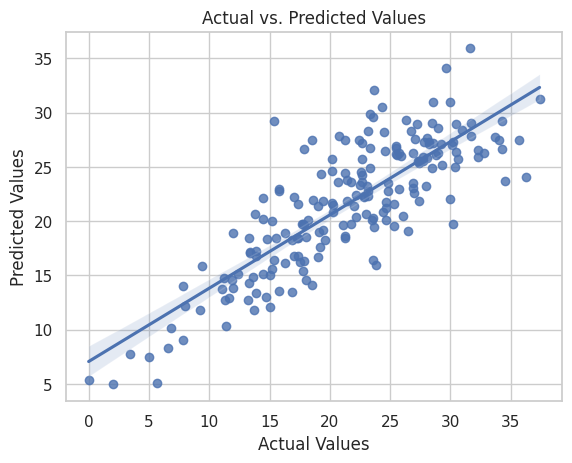

In [ ]:
# Make predictions using the model (for visualization)
predicted_values = model_pts.predict(X)

# Create a lineplot to visualize the performance of the linear regression model
sns.regplot(x=np.ravel(y_pts), y=np.ravel(predicted_values))
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()